In [1]:
import gym
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Blackjack-v1', natural=True)

### Часть 1

In [2]:
Q = {}

def choose_action_dummy(score):
    return 0 if score > 18 else 1

def choose_action_Q_learning(state, eps=0.1, act_size=2):
    if np.random.rand() < eps:
        action = np.random.choice(np.arange(act_size))
    else:
        if state not in Q:
            Q[state] = np.zeros(act_size)
        action = np.argmax(Q[state])
    return action

def single_game(method, eps=0.1, act_size=2):
    states = []
    actions = []
    state = env.reset()
    reward = 0
    while True:
        if method == 'dummy':
            action = choose_action_dummy(state[0])
        elif method == 'q':
            action = choose_action_Q_learning(state, eps, act_size)
        states.append(state)
        actions.append(action)            
        state, reward, done, _ = env.step(action)

        if done:
            break
    return states, actions, reward

def experiment(N_iters=1000000, method='dummy'):
    total = 0.
    for _ in range(N_iters):
        _, _, reward = single_game(method)
        total = total + reward
    return total / N_iters

In [3]:
def train(N_iters=100000, alpha=1e-5, gamma=1, eps=0.1, act_size=2):
    for _ in range(N_iters):
        states, actions, reward = single_game('q', eps, act_size)
        for state, action in zip(states[::-1],actions[::-1]):
            if state not in Q:
                Q[state] = np.zeros(act_size)
            reward = Q[state][action] + alpha * (reward + gamma * np.max(Q[state]) - Q[state][action])
            Q[state][action] = reward

def simulate(N_iters=100000, act_size=2):
    total = 0.
    for _ in range(N_iters):
        state = env.reset()
        while True:
            if state not in Q:
                Q[state] = np.zeros(act_size)
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action)
            if done:
                break
        total += reward
    return total/N_iters

In [4]:
train()

Средний выигрыш при глупой стратегии

In [5]:
experiment()

-0.197177

Средний выигрыш при Q обучении

In [6]:
simulate()

-0.08396

графики среднего дохода метода Q-learning (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения.

In [7]:
Q = {}
result = []
N_exps = 100
N_iters=1000
for i in tqdm(range(N_exps)):
    train(N_iters=N_iters)
    sub_result = simulate()
    result.append(sub_result)
    
avg = [result[0]]
for x in result[1:]:
    avg.append((avg[-1]*len(avg)+x)/(1. + len(avg)))

100%|██████████| 100/100 [06:48<00:00,  4.09s/it]


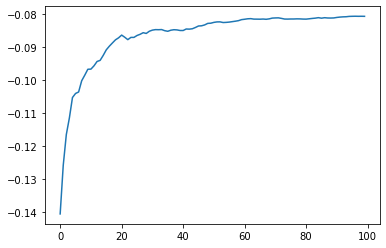

In [9]:
plt.plot(avg)

подберем eps и alpha

In [10]:
best = []
best_result = -1.
for alpha in tqdm(np.linspace(0.00001, 0.01, 10)):
    for eps in np.linspace(0.01, 0.4, 10):
        Q = {}
        train(N_iters=100000, alpha=alpha, eps=eps)
        result = simulate()
        if result > best_result:
            best_result = result
            best = [alpha, eps]
print(f"best_result: {best_result}, alpha: {best[0]}, eps: {best[1]}")

100%|██████████| 10/10 [15:21<00:00, 92.17s/it]

best_result: -0.05682, alpha: 1e-05, eps: 0.3566666666666667


### Часть 2

In [11]:
#новый step
def step(action):
    if action == 2:            
        state, reward, done, _ = env.step(1)
        if not done:              
            state, reward, done, _ = env.step(0)            
        return state, 2 * reward, done, _   
    else:
        return env.step(action)

# тут я дублирую код - я плохой человек
def single_game(method, eps=0.1, act_size=2):
    states = []
    actions = []
    state = env.reset()
    reward = 0
    while True:
        if method == 'dummy':
            action = choose_action_dummy(state[0])
        elif method == 'q':
            action = choose_action_Q_learning(state, eps, act_size)
        states.append(state)
        actions.append(action)            
        state, reward, done, _ = step(action)

        if done:
            break
    return states, actions, reward

def simulate(N_iters=100000, act_size=2):
    total = 0.
    for _ in range(N_iters):
        state = env.reset()
        while True:
            if state not in Q:
                Q[state] = np.zeros(act_size)
            action = np.argmax(Q[state])
            state, reward, done, _ = step(action)
            if done:
                break
        total += reward
    return total/N_iters

посмотрим, что там с выигрышем

In [12]:
Q = {}
train(N_iters=1000000, act_size=3)

In [13]:
simulate(N_iters=1000000, act_size=3)

-0.079572

построим график

In [14]:
Q = {}
result = []
N_exps = 100
N_iters=1000
for i in tqdm(range(N_exps)):
    train(N_iters=N_iters, act_size=3)
    sub_result = simulate(act_size=3)
    result.append(sub_result)
    
avg = [result[0]]
for x in result[1:]:
    avg.append((avg[-1]*len(avg)+x)/(1. + len(avg)))

100%|██████████| 100/100 [06:52<00:00,  4.12s/it]


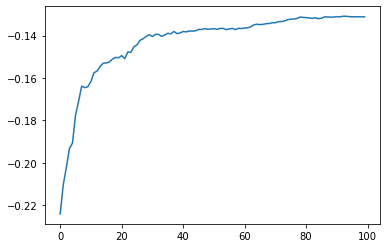

In [15]:
plt.plot(avg)

In [16]:
best = []
best_result = -1.
for alpha in tqdm(np.linspace(0.00001, 0.01, 10)):
    for eps in np.linspace(0.01, 0.4, 10):
        Q = {}
        train(N_iters=100000, alpha=alpha, eps=eps, act_size=3)
        result = simulate(act_size=3)
        if result > best_result:
            best_result = result
            best = [alpha, eps]
print(f"best_result: {best_result}, alpha: {best[0]}, eps: {best[1]}")

100%|██████████| 10/10 [15:19<00:00, 91.98s/it]

best_result: -0.07247, alpha: 1e-05, eps: 0.3184444444444444
